### Домашнее задание по лекции "Современные сверточные архитектуры"

##### Преподаватель: Алексей Миронов, Екатерина Апраксина

#### Возьмите датасет https://www.kaggle.com/ajayrana/hymenoptera-data/kernels
* 1. Обучите на нем модели ResNet 18 и VGG 16 с нуля (5-10 эпох)
* 2. Обучите на нем модели ResNet 18 и VGG 16 с использованием FineTuning (5-10 эпох)
* 3. Добавьте аугментацию данных к пункту 2
#### Сравните качество всех 3 полученных подходов

* Задание со звездочкой
#### Примените FineTuning ResNet 18 к FashionMnist. Удалось ли увидеть резкое увеличение качества?

In [14]:
import torch
from torch import nn
import torch.optim as optim
import torchvision as tv
import time
from torchvision import transforms, datasets, models
import os
from matplotlib import pyplot as plt

import time
from tqdm import tqdm

In [15]:
data_transforms = transforms.Compose([transforms.Resize((255,255)), transforms.ToTensor()]) 

In [16]:
data_dir = 'hymenoptera_data/'
BATCH_SIZE = 4

In [18]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=data_transforms)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter =  torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [19]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    net.eval()
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [20]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            # print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
            #     (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

### 1. Обучите на нем модели ResNet 18 и VGG 16 с нуля (5-10 эпох)

In [14]:
model_resnet18 = models.resnet18(pretrained=False)
for param in model_resnet18.parameters():
    param.requires_grad = True
model_resnet18.fc = nn.Linear(in_features=512, out_features=2)
model_resnet18.fc

Linear(in_features=512, out_features=2, bias=True)

In [15]:
print("Params to learn:")
params_to_update = []
names=[]
for name, param in model_resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        names+= [name]
print("\t", names)
        

Params to learn:
	 ['conv1.weight', 'bn1.weight', 'bn1.bias', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.downsample.0.weight', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.1.conv1.weight', 'layer2.1.bn1.weight', 'layer2.1.bn1.bias', 'layer2.1.conv2.weight', 'layer2.1.bn2.weight', 'layer2.1.bn2.bias', 'layer3.0.conv1.weight', 'layer3.0.bn1.weight', 'layer3.0.bn1.bias', 'layer3.0.conv2.weight', 'layer3.0.bn2.weight', 'layer3.0.bn2.bias', 'layer3.0.downsample.0.weight', 'layer3.0.downsample.1.weight', 'layer3.0.downsample.1.bias', 'layer3.1.conv1.weight', 'layer3.1.bn1.weight', 'layer3.1.bn

In [16]:
trainer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [17]:
train(model_resnet18, train_iter, test_iter, trainer, 5)

epoch 1, loss 1.1693, train acc 0.914, test acc 0.542, time 54.0 sec
epoch 2, loss nan, train acc 0.471, test acc 0.458, time 49.9 sec
epoch 3, loss nan, train acc 0.504, test acc 0.458, time 49.3 sec
epoch 4, loss nan, train acc 0.504, test acc 0.458, time 48.0 sec
epoch 5, loss nan, train acc 0.504, test acc 0.458, time 50.9 sec


In [18]:
model_vgg16= models.vgg16(pretrained=False)
for param in model_vgg16.parameters():
    param.requires_grad = True


In [19]:
model_vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
model_vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [20]:
print("Params to learn:")
params_to_update = []
names=[]
for name, param in model_vgg16.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        names+= [name]
print("\t", names)

Params to learn:
	 ['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias']


In [21]:
trainer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [23]:
train(model_vgg16, train_iter, test_iter, trainer, 5)

epoch 1, loss 1.4799, train acc 0.914, test acc 0.542, time 484.4 sec
epoch 2, loss nan, train acc 0.488, test acc 0.458, time 306.2 sec
epoch 3, loss nan, train acc 0.504, test acc 0.458, time 300.0 sec
epoch 4, loss nan, train acc 0.504, test acc 0.458, time 302.0 sec
epoch 5, loss nan, train acc 0.504, test acc 0.458, time 260.1 sec


### 2. Обучите на нем модели ResNet 18 и VGG 16 с использованием FineTuning (5-10 эпох)

In [24]:
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(in_features=512, out_features=2)
resnet18.fc

Linear(in_features=512, out_features=2, bias=True)

In [25]:
print("Params to learn:")
params_to_update = []
names=[]
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        names+= [name]
print("\t", names)
        

Params to learn:
	 ['fc.weight', 'fc.bias']


In [26]:
trainer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [27]:
train(resnet18, train_iter, test_iter, trainer, 5)

epoch 1, loss 0.5573, train acc 0.947, test acc 0.542, time 20.6 sec
epoch 2, loss 25.1348, train acc 0.676, test acc 0.542, time 20.3 sec
epoch 3, loss 35.4890, train acc 0.615, test acc 0.542, time 23.5 sec
epoch 4, loss 20.2691, train acc 0.680, test acc 0.601, time 24.2 sec
epoch 5, loss 7.8172, train acc 0.783, test acc 0.739, time 24.1 sec


In [30]:
vgg16= models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False


In [31]:
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [32]:
print("Params to learn:")
params_to_update = []
names=[]
for name, param in vgg16.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        names+= [name]
print("\t", names)

Params to learn:
	 ['classifier.6.weight', 'classifier.6.bias']


In [33]:
trainer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [34]:
train(vgg16, train_iter, test_iter, trainer, 5)

epoch 1, loss 0.9781, train acc 0.922, test acc 0.542, time 102.6 sec
epoch 2, loss 18.1183, train acc 0.689, test acc 0.542, time 85.3 sec
epoch 3, loss 8.4380, train acc 0.783, test acc 0.882, time 83.2 sec
epoch 4, loss 2.1147, train acc 0.889, test acc 0.902, time 81.1 sec
epoch 5, loss 0.9825, train acc 0.934, test acc 0.876, time 81.3 sec


### 3. Добавьте аугментацию данных к пункту 2

In [36]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j], cmap='gray')
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    plt.show()

In [37]:
augs = tv.transforms.Compose([
       tv.transforms.RandomHorizontalFlip(),
       tv.transforms.RandomVerticalFlip(),
       tv.transforms.RandomResizedCrop(
            (255, 255), scale=(0.1, 1), ratio=(0.5, 2)),
       tv.transforms.ToTensor()])

In [38]:
train_dataset2 = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=augs)
test_dataset2 = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=augs)
train_iter2 = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter2 =  torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

torch.Size([4, 3, 255, 255])


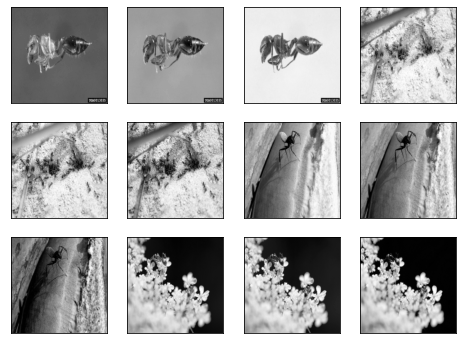

In [39]:
for X, _ in train_iter2:
    print(X.shape)
    X = X.reshape(12, 255, 255)
    show_images(X, 3, 4)    
    break

In [54]:
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(in_features=512, out_features=2)
resnet18.fc

Linear(in_features=512, out_features=2, bias=True)

In [55]:
print("Params to learn:")
params_to_update = []
names=[]
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        names+= [name]
print("\t", names)
        

Params to learn:
	 ['fc.weight', 'fc.bias']


In [56]:
trainer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [57]:
train(resnet18, train_iter2, test_iter2, trainer, 5)

epoch 1, loss 1.3198, train acc 0.914, test acc 0.542, time 19.4 sec
epoch 2, loss 28.9694, train acc 0.664, test acc 0.542, time 18.3 sec
epoch 3, loss 34.8637, train acc 0.615, test acc 0.542, time 16.7 sec
epoch 4, loss 19.1774, train acc 0.684, test acc 0.608, time 16.7 sec
epoch 5, loss 7.3639, train acc 0.783, test acc 0.752, time 16.8 sec


In [58]:
vgg16= models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False

In [59]:
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [60]:
print("Params to learn:")
params_to_update = []
names=[]
for name, param in vgg16.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        names+= [name]
print("\t", names)

Params to learn:
	 ['classifier.6.weight', 'classifier.6.bias']


In [61]:
trainer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [62]:
train(vgg16, train_iter2, test_iter2, trainer, 5)

epoch 1, loss 0.8225, train acc 0.939, test acc 0.542, time 88.5 sec
epoch 2, loss 18.2819, train acc 0.689, test acc 0.542, time 89.0 sec
epoch 3, loss 8.4026, train acc 0.783, test acc 0.869, time 85.8 sec
epoch 4, loss 2.4665, train acc 0.877, test acc 0.895, time 82.8 sec
epoch 5, loss 1.1431, train acc 0.922, test acc 0.863, time 88.9 sec


#### Итоги:
1. Обучение с нуля:
* resnet18: epoch 5, loss nan, train acc 0.504, test acc 0.458, time 50.9 sec
* vgg16: epoch 5, loss nan, train acc 0.504, test acc 0.458, time 260.1 sec

2. Transfer Learning:
* resnet18: epoch 5, loss 7.8172, train acc 0.783, test acc 0.739, time 24.1 sec
* vgg16: epoch 5, loss 0.9825, train acc 0.934, test acc 0.876, time 81.3 sec

3. Апроксимация:
* resnet18: epoch 5, loss 7.3639, train acc 0.783, test acc 0.752, time 16.8 sec
* vgg16: epoch 5, loss 1.1431, train acc 0.922, test acc 0.863, time 88.9 sec

##### При равном кол-ве эпох лучшие результаты показала VGG16 с предобученными весами.
##### Апроксимация дала небольшое улучшение для ResNet18 с предобученными весам.


### 4. Примените FineTuning ResNet 18 к FashionMnist. Удалось ли увидеть резкое увеличение качества?

In [21]:
BATCH_SIZE=256

In [22]:
transforms4 = tv.transforms.Compose([
              tv.transforms.Grayscale(3),    
              tv.transforms.RandomHorizontalFlip(),
              tv.transforms.RandomVerticalFlip(),           
              tv.transforms.RandomResizedCrop((28, 28), scale=(0.1, 1), ratio=(0.5, 2)),      
              tv.transforms.ToTensor()])

train_dataset4 = tv.datasets.FashionMNIST('.', train=True, transform=transforms4, download=True)
test_dataset4 = tv.datasets.FashionMNIST('.', train=False, transform=transforms4, download=True)
train_iter4 = torch.utils.data.DataLoader(train_dataset4, batch_size=BATCH_SIZE)
test_iter4 = torch.utils.data.DataLoader(test_dataset4, batch_size=BATCH_SIZE)

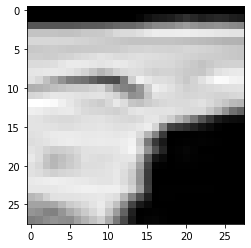

In [23]:
plt.imshow(train_dataset4[0][0][0].numpy().reshape(28,28), cmap='gray')

In [25]:
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(in_features=512, out_features=10)
resnet18.fc

Linear(in_features=512, out_features=10, bias=True)

In [26]:
print("Params to learn:")
params_to_update = []
names=[]
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        names+= [name]
print("\t", names)
        

Params to learn:
	 ['fc.weight', 'fc.bias']


In [27]:
trainer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [29]:
train(resnet18, train_iter4, test_iter4, trainer, 10)

epoch 1, loss 11.3704, train acc 0.368, test acc 0.336, time 287.8 sec
epoch 2, loss 11.6501, train acc 0.374, test acc 0.409, time 284.3 sec
epoch 3, loss 10.7690, train acc 0.377, test acc 0.350, time 280.5 sec
epoch 4, loss 10.7767, train acc 0.376, test acc 0.343, time 257.3 sec
epoch 5, loss 10.5868, train acc 0.375, test acc 0.319, time 293.2 sec
epoch 6, loss 11.2688, train acc 0.374, test acc 0.383, time 308.4 sec
epoch 7, loss 10.8884, train acc 0.375, test acc 0.395, time 297.3 sec
epoch 8, loss 10.7207, train acc 0.378, test acc 0.352, time 276.3 sec
epoch 9, loss 11.7948, train acc 0.372, test acc 0.361, time 263.6 sec
epoch 10, loss 11.4062, train acc 0.377, test acc 0.375, time 248.3 sec


In [89]:
model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding=2),
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),   
    nn.Flatten(),
    nn.Linear(300, 50),   
    nn.ReLU(),
    nn.Linear(50, 10)
)

In [90]:
trainer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, train_iter4, test_iter4, trainer, 10)

epoch 1, loss 1.4886, train acc 0.440, test acc 0.516, time 37.8 sec
epoch 2, loss 2.1557, train acc 0.217, test acc 0.100, time 38.6 sec
epoch 3, loss 2.3055, train acc 0.100, test acc 0.100, time 38.0 sec
epoch 4, loss 2.3054, train acc 0.100, test acc 0.100, time 37.5 sec
epoch 5, loss 2.3054, train acc 0.100, test acc 0.100, time 36.7 sec
epoch 6, loss 2.3054, train acc 0.100, test acc 0.100, time 36.2 sec
epoch 7, loss 2.3054, train acc 0.100, test acc 0.100, time 38.7 sec
epoch 8, loss 2.3054, train acc 0.100, test acc 0.100, time 40.4 sec
epoch 9, loss 2.3054, train acc 0.100, test acc 0.100, time 37.1 sec
epoch 10, loss 2.3054, train acc 0.100, test acc 0.100, time 35.2 sec


##### Вывод: Качество на ResNet18 улучшилось